# 11강: 딥러닝 신경망 (CNN)

## 🎯 학습 목표
- 컨볼루션 신경망(CNN)의 핵심 개념 완전 이해
- 컨볼루션과 풀링 연산을 함수로 직접 구현
- CNN이 이미지 처리에 효과적인 이유 체험
- 손글씨 숫자 인식으로 CNN의 실력 확인

---

## 📚 강의 개요 (60분)
1. **CNN 개념과 필요성** (15분)
2. **컨볼루션 연산 이해** (15분)  
3. **풀링과 CNN 구조** (15분)
4. **함수로 CNN 구현** (15분)

> **10강 복습**: 다층 신경망으로 XOR 문제를 해결했습니다. 이제 이미지 처리의 혁신인 CNN을 배워봅시다!

---

## 🤔 왜 CNN이 필요할까요?

### 기존 신경망의 한계
**📸 이미지를 일반 신경망으로 처리한다면?**
- 28×28 이미지 → 784개 입력 뉴런 필요
- 컬러 이미지(224×224×3) → 150,528개 입력 뉴런!
- 첫 번째 은닉층(1000뉴런) → 150,528,000개 가중치!

**❌ 문제점들:**
1. **너무 많은 매개변수** → 메모리 부족, 학습 느림
2. **위치 정보 손실** → 이미지를 1차원으로 펼치면서 공간 정보 사라짐
3. **변이에 취약** → 같은 물체라도 위치가 바뀌면 다른 것으로 인식

### CNN의 해결책
**✅ CNN의 핵심 아이디어:**
1. **지역적 연결**: 전체가 아닌 일부 영역만 연결
2. **가중치 공유**: 같은 필터를 이미지 전체에 적용  
3. **계층적 특성 추출**: 저수준 → 고수준 특성 순차 학습

**🔥 결과: 훨씬 적은 매개변수로 더 좋은 성능!**


=== CNN 학습을 위한 환경 설정 ===
PyTorch 버전: 1.10.1+cu102
CUDA 사용 가능: True

🎨 먼저 간단한 이미지로 CNN의 동작을 이해해봅시다!
간단한 십자가 이미지 (5×5):
tensor([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])


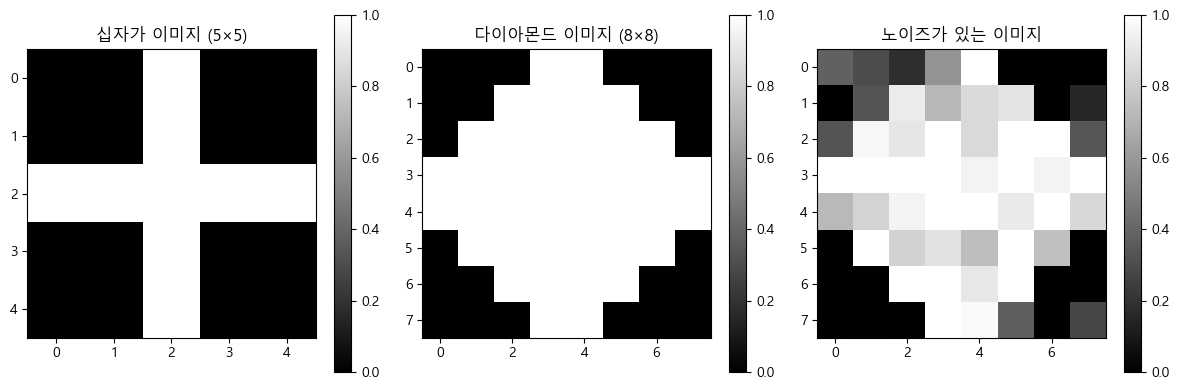


📊 이미지들의 기본 정보:
십자가 이미지 shape: torch.Size([5, 5])
다이아몬드 이미지 shape: torch.Size([8, 8])
노이즈 이미지 shape: torch.Size([8, 8])

✅ 환경 설정 완료! 이제 컨볼루션 연산을 배워봅시다.


In [1]:
# CNN 시작을 위한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

print("=== CNN 학습을 위한 환경 설정 ===")
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")

# 한글 폰트 설정
import matplotlib.font_manager as fm
f = [f.name for f in fm.fontManager.ttflist]
# print(f)
# 확인 이후
plt.rc('font', family='Malgun Gothic')

# 재현 가능한 결과를 위한 시드 설정
torch.manual_seed(42)
np.random.seed(42)

print("\n🎨 먼저 간단한 이미지로 CNN의 동작을 이해해봅시다!")

# 간단한 이미지 예제 생성 (5×5 이미지)
simple_image = torch.tensor([
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0], 
    [1, 1, 1, 1, 1],
    [0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0]
], dtype=torch.float32)

print("간단한 십자가 이미지 (5×5):")
print(simple_image)

# 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(simple_image, cmap='gray')
plt.title('십자가 이미지 (5×5)')
plt.colorbar()

# 좀 더 복잡한 이미지 (8×8)
complex_image = torch.tensor([
    [0, 0, 0, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1], 
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0]
], dtype=torch.float32)

plt.subplot(1, 3, 2)
plt.imshow(complex_image, cmap='gray')
plt.title('다이아몬드 이미지 (8×8)')
plt.colorbar()

# 노이즈가 있는 이미지
noisy_image = complex_image + 0.2 * torch.randn_like(complex_image)
noisy_image = torch.clamp(noisy_image, 0, 1)  # 0~1 범위로 제한

plt.subplot(1, 3, 3)
plt.imshow(noisy_image, cmap='gray')
plt.title('노이즈가 있는 이미지')
plt.colorbar()

plt.tight_layout()
plt.show()

print("\n📊 이미지들의 기본 정보:")
print(f"십자가 이미지 shape: {simple_image.shape}")
print(f"다이아몬드 이미지 shape: {complex_image.shape}")
print(f"노이즈 이미지 shape: {noisy_image.shape}")

print("\n✅ 환경 설정 완료! 이제 컨볼루션 연산을 배워봅시다.")


## 1. 컨볼루션 연산 이해하기

### 1.1 컨볼루션이란?

**🔍 컨볼루션(Convolution): 필터를 이미지 위에서 슬라이딩하며 특성을 추출하는 연산**

**📏 핵심 개념:**
- **필터(Filter/커널)**: 작은 크기의 가중치 행렬 (예: 3×3, 5×5)
- **슬라이딩**: 필터를 이미지 전체에서 한 칸씩 이동
- **내적**: 필터와 이미지 부분의 원소별 곱셈 후 합산
- **특성 맵**: 컨볼루션 결과로 생성되는 새로운 이미지

### 1.2 컨볼루션 연산 과정

**🎯 단계별 과정:**
```
1. 필터를 이미지 왼쪽 위에 놓기
2. 필터와 해당 영역의 원소별 곱셈
3. 모든 곱셈 결과를 합산 (스칼라 값)
4. 결과를 특성 맵에 저장
5. 필터를 오른쪽으로 한 칸 이동
6. 2-5 과정 반복 (끝까지)
```

### 1.3 주요 하이퍼파라미터

**⚙️ 컨볼루션 설정 매개변수:**

| 매개변수 | 설명 | 영향 | 일반적 값 |
|----------|------|------|-----------|
| **Kernel Size** | 필터 크기 | 수용 영역 크기 | 3×3, 5×5, 7×7 |
| **Stride** | 필터 이동 간격 | 출력 크기, 계산량 | 1, 2 |
| **Padding** | 가장자리 채우기 | 출력 크기 유지 | 0, 1, 2 |
| **Dilation** | 필터 간격 확장 | 더 넓은 수용 영역 | 1, 2 |

### 1.4 출력 크기 계산 공식

**📐 출력 크기 공식:**
```
출력 크기 = (입력 크기 - 커널 크기 + 2×패딩) / 스트라이드 + 1
```

**예시:**
- 입력: 5×5, 커널: 3×3, 패딩: 0, 스트라이드: 1
- 출력: (5-3+0)/1 + 1 = 3×3

### 1.5 다양한 필터의 역할

**🎨 필터별 특성 추출:**
- **엣지 검출**: 경계선 찾기
- **블러**: 이미지 부드럽게 만들기  
- **샤프닝**: 이미지 선명하게 만들기
- **엠보싱**: 양각 효과

**💡 CNN의 핵심: 학습을 통해 최적의 필터 자동 발견!**


=== 함수로 컨볼루션 연산 구현하기 ===

🎨 다양한 필터들을 정의해봅시다:
필터 종류:
• 세로 엣지: torch.Size([3, 3])
• 가로 엣지: torch.Size([3, 3])
• Sobel X: torch.Size([3, 3])
• Sobel Y: torch.Size([3, 3])
• 블러: torch.Size([3, 3])
• 샤프닝: torch.Size([3, 3])

=== 십자가 이미지에 각 필터 적용 ===
입력 이미지 크기: torch.Size([5, 5])
세로 엣지 결과 크기: torch.Size([3, 3])
가로 엣지 결과 크기: torch.Size([3, 3])
Sobel X 결과 크기: torch.Size([3, 3])
Sobel Y 결과 크기: torch.Size([3, 3])
블러 결과 크기: torch.Size([3, 3])
샤프닝 결과 크기: torch.Size([3, 3])


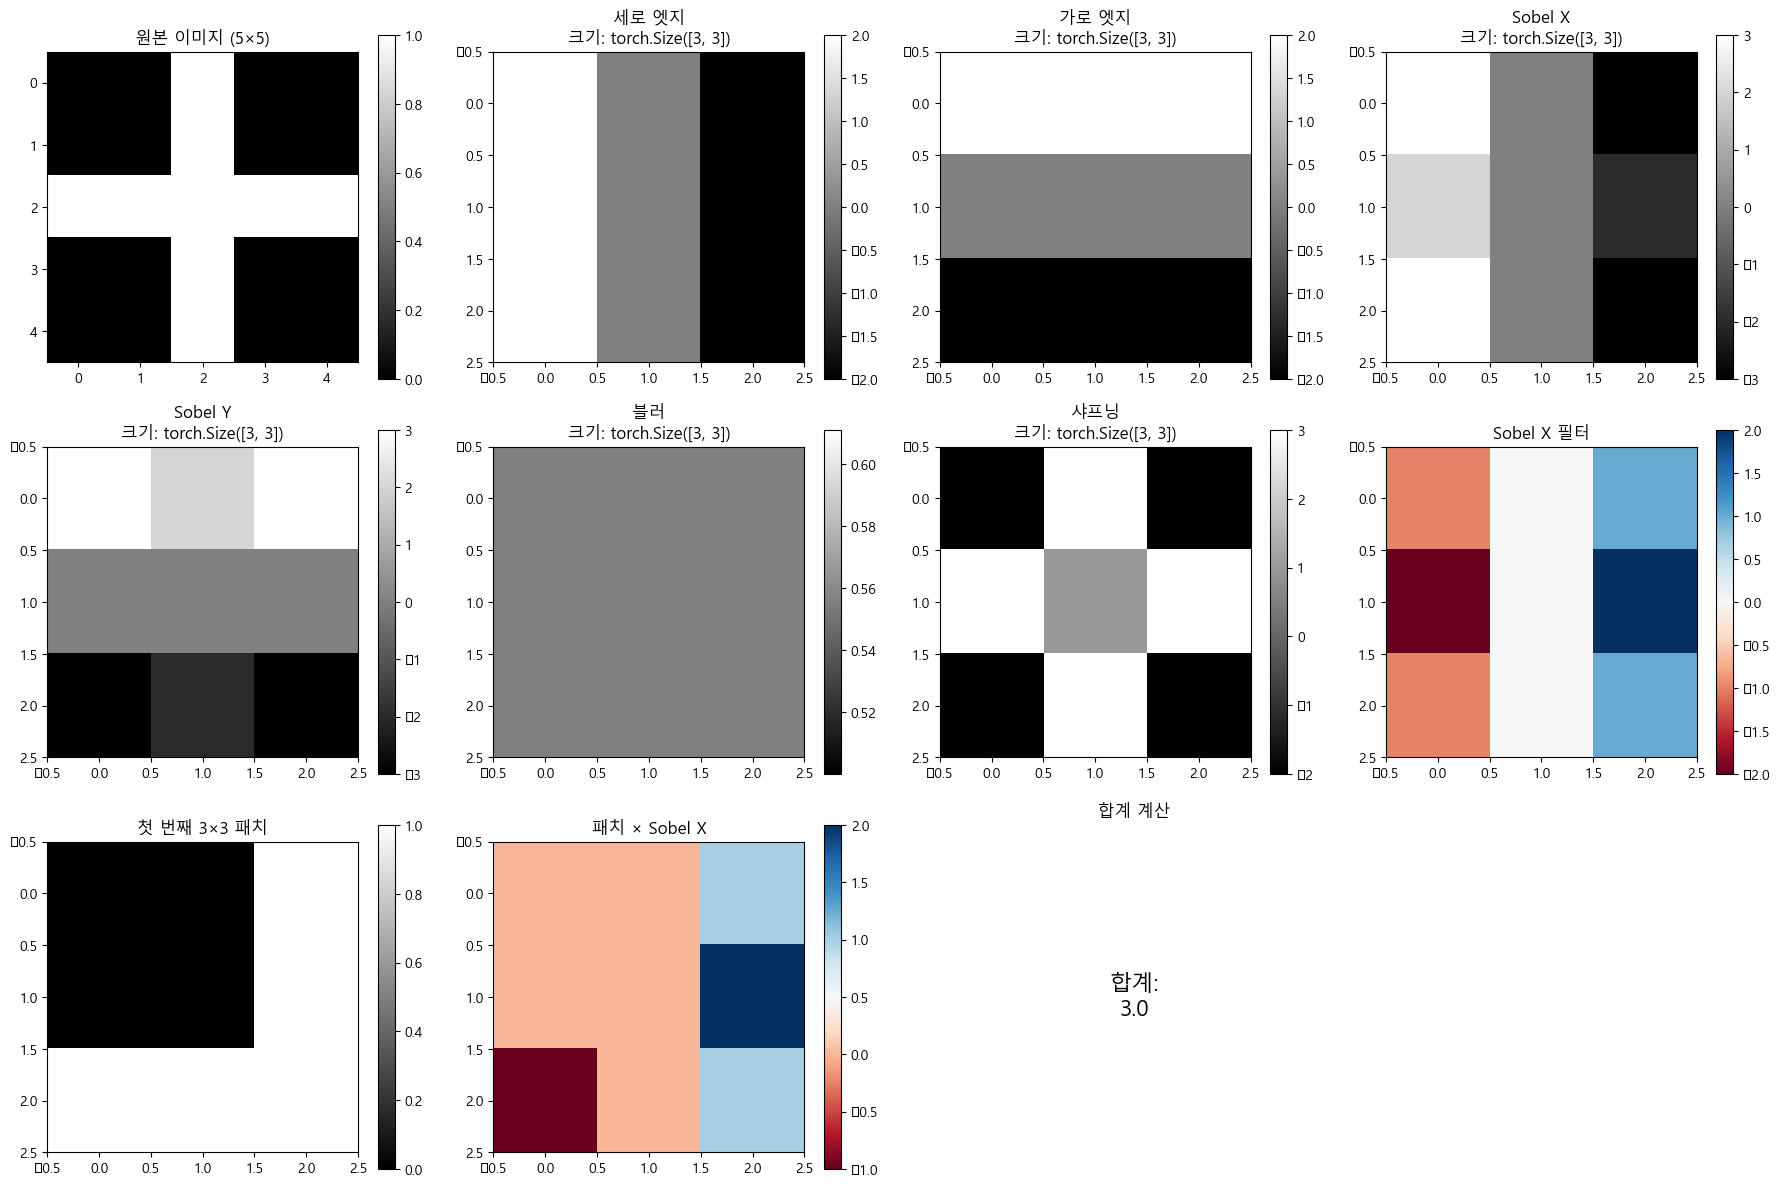


📊 각 필터의 수치적 결과:

세로 엣지:
  최솟값: -2.00
  최댓값: 2.00
  평균: 0.00
  결과:
tensor([[ 2.,  0., -2.],
        [ 2.,  0., -2.],
        [ 2.,  0., -2.]])

가로 엣지:
  최솟값: -2.00
  최댓값: 2.00
  평균: 0.00
  결과:
tensor([[ 2.,  2.,  2.],
        [ 0.,  0.,  0.],
        [-2., -2., -2.]])

Sobel X:
  최솟값: -3.00
  최댓값: 3.00
  평균: 0.00
  결과:
tensor([[ 3.,  0., -3.],
        [ 2.,  0., -2.],
        [ 3.,  0., -3.]])

Sobel Y:
  최솟값: -3.00
  최댓값: 3.00
  평균: 0.00
  결과:
tensor([[ 3.,  2.,  3.],
        [ 0.,  0.,  0.],
        [-3., -2., -3.]])

블러:
  최솟값: 0.56
  최댓값: 0.56
  평균: 0.56
  결과:
tensor([[0.5556, 0.5556, 0.5556],
        [0.5556, 0.5556, 0.5556],
        [0.5556, 0.5556, 0.5556]])

샤프닝:
  최솟값: -2.00
  최댓값: 3.00
  평균: 0.56
  결과:
tensor([[-2.,  3., -2.],
        [ 3.,  1.,  3.],
        [-2.,  3., -2.]])

✅ 컨볼루션 연산 구현 및 테스트 완료!


In [2]:
# 함수로 컨볼루션 연산 직접 구현하기
print("=== 함수로 컨볼루션 연산 구현하기 ===")

def convolution_2d(image, kernel, stride=1, padding=0):
    """
    2D 컨볼루션 연산을 직접 구현
    
    Args:
        image: 입력 이미지 (H, W)
        kernel: 필터/커널 (K, K)  
        stride: 스트라이드 (기본값: 1)
        padding: 패딩 (기본값: 0)
    
    Returns:
        output: 컨볼루션 결과 (H', W')
    """
    # 입력 크기
    H, W = image.shape
    K, _ = kernel.shape
    
    # 패딩 적용
    if padding > 0:
        padded_image = torch.zeros(H + 2*padding, W + 2*padding)
        padded_image[padding:H+padding, padding:W+padding] = image
    else:
        padded_image = image
    
    # 출력 크기 계산
    H_padded, W_padded = padded_image.shape
    H_out = (H_padded - K) // stride + 1
    W_out = (W_padded - K) // stride + 1
    
    # 출력 텐서 초기화
    output = torch.zeros(H_out, W_out)
    
    # 컨볼루션 연산
    for i in range(H_out):
        for j in range(W_out):
            # 현재 위치에서 필터 크기만큼 추출
            h_start = i * stride
            h_end = h_start + K
            w_start = j * stride  
            w_end = w_start + K
            
            # 이미지 패치와 커널의 원소별 곱셈 후 합
            patch = padded_image[h_start:h_end, w_start:w_end]
            output[i, j] = torch.sum(patch * kernel)
    
    return output

# 다양한 필터 정의
print("\n🎨 다양한 필터들을 정의해봅시다:")

# 1. 엣지 검출 필터들
edge_vertical = torch.tensor([
    [-1, 0, 1],
    [-1, 0, 1], 
    [-1, 0, 1]
], dtype=torch.float32)

edge_horizontal = torch.tensor([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
], dtype=torch.float32)

sobel_x = torch.tensor([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=torch.float32)

sobel_y = torch.tensor([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=torch.float32)

# 2. 블러 필터
blur = torch.tensor([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
], dtype=torch.float32) / 9  # 정규화

# 3. 샤프닝 필터
sharpen = torch.tensor([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=torch.float32)

# 필터들을 딕셔너리에 저장
filters = {
    "세로 엣지": edge_vertical,
    "가로 엣지": edge_horizontal, 
    "Sobel X": sobel_x,
    "Sobel Y": sobel_y,
    "블러": blur,
    "샤프닝": sharpen
}

print("필터 종류:")
for name, filter_tensor in filters.items():
    print(f"• {name}: {filter_tensor.shape}")

# 각 필터를 십자가 이미지에 적용
print(f"\n=== 십자가 이미지에 각 필터 적용 ===")
print(f"입력 이미지 크기: {simple_image.shape}")

# 결과 저장용
results = {}

for filter_name, filter_kernel in filters.items():
    result = convolution_2d(simple_image, filter_kernel)
    results[filter_name] = result
    print(f"{filter_name} 결과 크기: {result.shape}")

# 시각화
plt.figure(figsize=(18, 12))

# 원본 이미지
plt.subplot(3, 4, 1)
plt.imshow(simple_image, cmap='gray')
plt.title('원본 이미지 (5×5)')
plt.colorbar()

# 각 필터 결과
for i, (filter_name, result) in enumerate(results.items(), 2):
    plt.subplot(3, 4, i)
    plt.imshow(result, cmap='gray')
    plt.title(f'{filter_name}\n크기: {result.shape}')
    plt.colorbar()

# 필터 시각화
plt.subplot(3, 4, 8)
filter_to_show = sobel_x
plt.imshow(filter_to_show, cmap='RdBu')
plt.title('Sobel X 필터')
plt.colorbar()

# 컨볼루션 과정 단계별 시각화
plt.subplot(3, 4, 9)
# 첫 번째 위치에서의 컨볼루션 계산 보여주기
patch = simple_image[0:3, 0:3]  # 3x3 패치 추출
plt.imshow(patch, cmap='gray')
plt.title('첫 번째 3×3 패치')
plt.colorbar()

plt.subplot(3, 4, 10)
# 패치와 필터의 원소별 곱셈
multiplication = patch * sobel_x
plt.imshow(multiplication, cmap='RdBu')
plt.title('패치 × Sobel X')
plt.colorbar()

plt.subplot(3, 4, 11)
# 합계 결과
sum_result = torch.sum(multiplication)
plt.text(0.5, 0.5, f'합계:\n{sum_result:.1f}', 
         ha='center', va='center', fontsize=16, 
         transform=plt.gca().transAxes)
plt.title('합계 계산')
plt.axis('off')

plt.tight_layout()
plt.show()

# 수치적 결과 분석
print(f"\n📊 각 필터의 수치적 결과:")
for filter_name, result in results.items():
    print(f"\n{filter_name}:")
    print(f"  최솟값: {result.min():.2f}")
    print(f"  최댓값: {result.max():.2f}")
    print(f"  평균: {result.mean():.2f}")
    print(f"  결과:\n{result}")

print("\n✅ 컨볼루션 연산 구현 및 테스트 완료!")


## 2. 풀링 연산과 CNN 구조

### 2.1 풀링(Pooling)이란?

**🏊‍♂️ 풀링: 특성 맵의 크기를 줄이고 중요한 정보만 유지하는 연산**

**📉 풀링의 목적:**
1. **차원 축소**: 특성 맵 크기 감소 → 계산량 감소
2. **불변성 확보**: 작은 위치 변화에 덜 민감하게 만듦  
3. **오버피팅 방지**: 매개변수 수 감소로 일반화 성능 향상
4. **수용 영역 확대**: 더 넓은 영역의 정보를 다음 층에서 볼 수 있음

### 2.2 주요 풀링 방법들

**🎯 대표적인 풀링 연산:**

| 풀링 방법 | 연산 | 특징 | 언제 사용? |
|-----------|------|------|-----------|
| **Max Pooling** | 최댓값 선택 | 가장 강한 신호 유지 | 일반적으로 가장 많이 사용 |
| **Average Pooling** | 평균값 계산 | 전체적인 경향 유지 | 부드러운 특성 원할 때 |
| **Global Average Pooling** | 전체 평균 | 모든 위치 정보 통합 | 마지막 층에서 주로 사용 |

### 2.3 CNN 기본 구조

**🏗️ 전형적인 CNN 아키텍처:**

```
입력 이미지
    ↓
[Conv → ReLU → Pool] × N  ← 특성 추출 단계
    ↓
[Flatten] ← 1차원 변환
    ↓  
[FC → ReLU] × M ← 분류 단계
    ↓
[FC → Softmax] ← 출력 층
    ↓
예측 결과
```

### 2.4 대표적인 CNN 아키텍처

**📚 CNN 발전 역사:**

| 모델 | 연도 | 특징 | 혁신점 |
|------|------|------|--------|
| **LeNet-5** | 1998 | 최초의 CNN | 손글씨 인식 성공 |
| **AlexNet** | 2012 | 딥러닝 부흥 | GPU 활용, 드롭아웃 |
| **VGGNet** | 2014 | 간단한 구조 | 3×3 필터만 사용 |
| **ResNet** | 2015 | 매우 깊은 네트워크 | 잔차 연결 |

### 2.5 특성 맵의 변화 과정

**🔄 CNN에서 특성 맵이 변하는 과정:**

1. **저수준 특성** (초기 층)
   - 엣지, 코너, 색상 변화
   - 작은 필터, 많은 특성 맵

2. **중간 수준 특성** (중간 층)  
   - 텍스처, 패턴, 형태
   - 복합적인 특성 조합

3. **고수준 특성** (후반 층)
   - 객체의 일부분, 의미있는 구조
   - 최종 분류에 직접 도움

**💡 핵심: 층이 깊어질수록 더 복잡하고 의미있는 특성을 학습!**


=== 함수로 풀링 연산 구현하기 ===
테스트 이미지 크기: torch.Size([8, 8])
테스트 이미지:
tensor([[1., 2., 3., 4., 5., 6., 7., 8.],
        [2., 4., 6., 8., 1., 3., 5., 7.],
        [3., 6., 9., 2., 4., 8., 1., 5.],
        [4., 8., 2., 6., 7., 1., 9., 3.],
        [5., 1., 4., 7., 2., 9., 6., 8.],
        [6., 3., 8., 1., 9., 2., 4., 7.],
        [7., 5., 1., 9., 6., 4., 8., 2.],
        [8., 7., 5., 3., 8., 7., 2., 6.]])

=== 다양한 풀링 연산 적용 ===

Max Pooling 결과 크기: torch.Size([4, 4])
Max Pooling 결과:
tensor([[4., 8., 6., 8.],
        [8., 9., 8., 9.],
        [6., 8., 9., 8.],
        [8., 9., 8., 8.]])

Average Pooling 결과 크기: torch.Size([4, 4])
Average Pooling 결과:
tensor([[2.2500, 5.2500, 3.7500, 6.7500],
        [5.2500, 4.7500, 5.0000, 4.5000],
        [3.7500, 5.0000, 5.5000, 6.2500],
        [6.7500, 4.5000, 6.2500, 4.5000]])

4×4 Max Pooling 결과 크기: torch.Size([2, 2])
4×4 Max Pooling 결과:
tensor([[9., 9.],
        [9., 9.]])

4×4 Average Pooling 결과 크기: torch.Size([2, 2])
4×4 Average Pooling 결과:
tensor([[4.3750

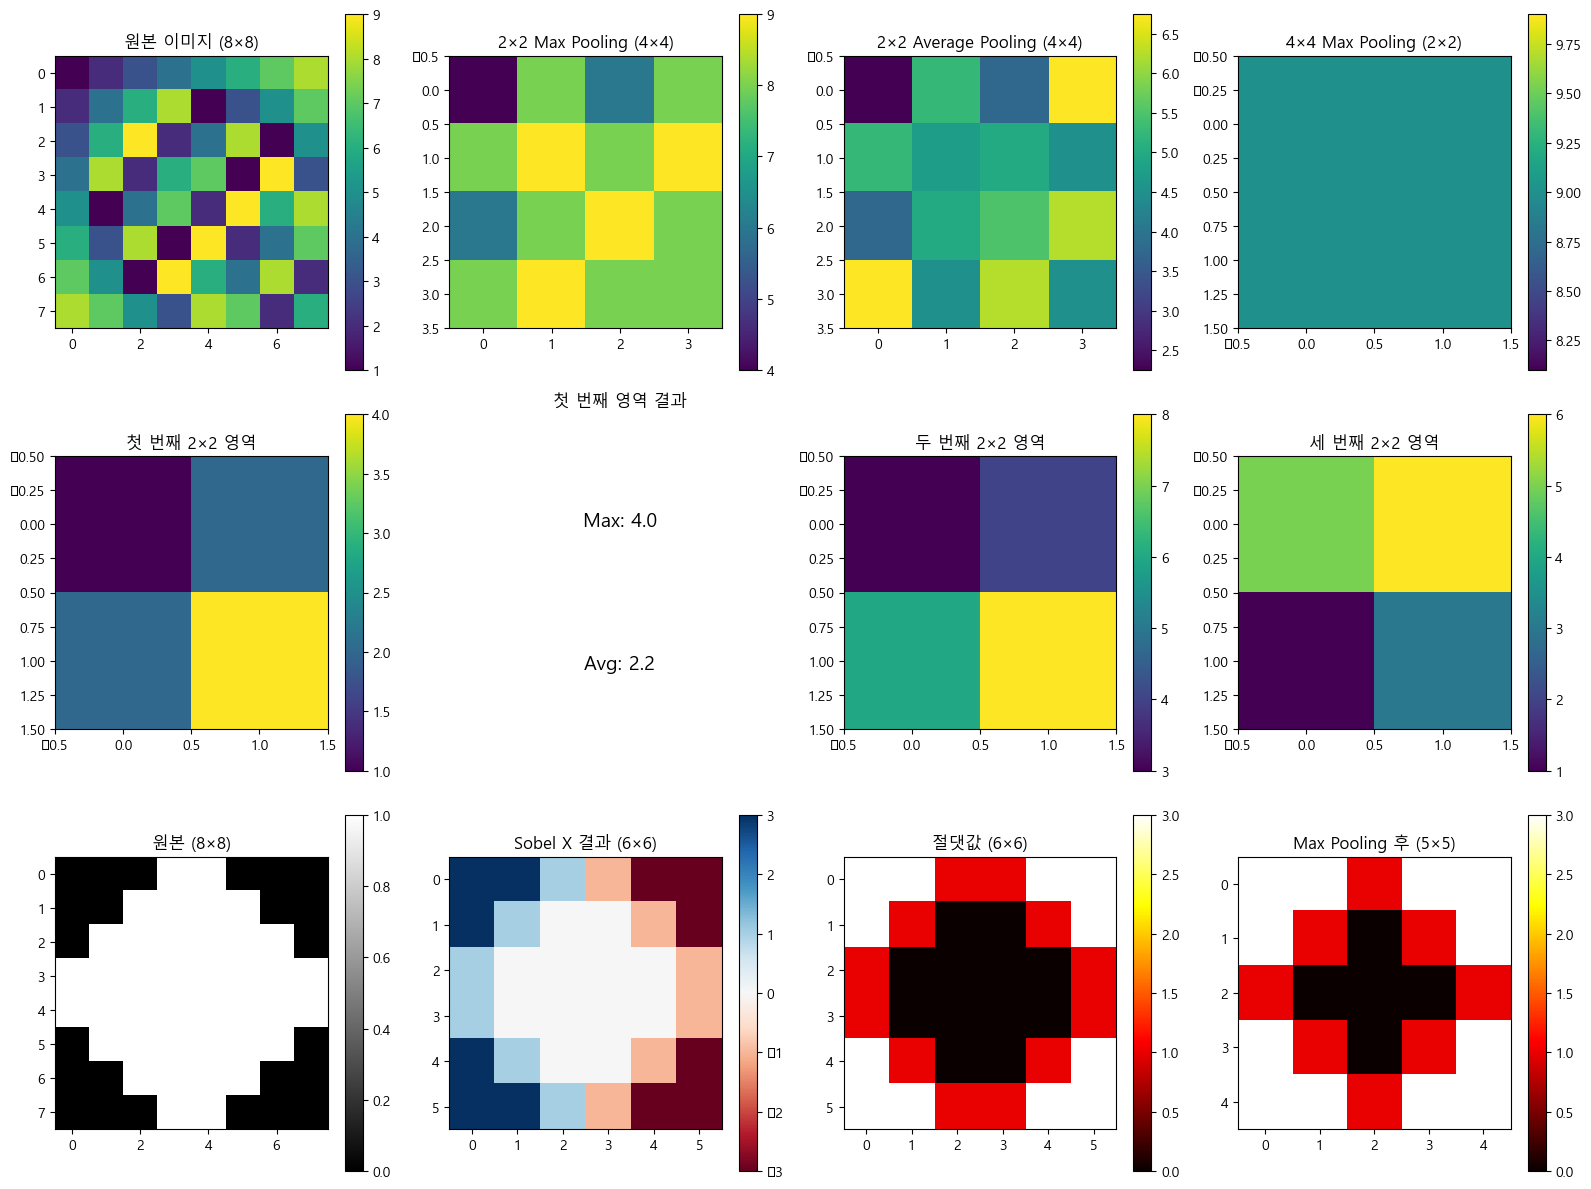


📊 풀링의 효과 분석:
원본 이미지 크기: torch.Size([8, 8]) → 원소 개수: 64
2×2 Max Pooling: torch.Size([4, 4]) → 원소 개수: 16 (25% 유지)
4×4 Max Pooling: torch.Size([2, 2]) → 원소 개수: 4 (6.25% 유지)

정보 유지 정도:
Max Pooling - 최댓값: 9.0 → 9.0
Average Pooling - 평균값: 5.0 → 5.0

✅ 풀링 연산 구현 및 테스트 완료!


In [3]:
# 함수로 풀링 연산 구현하기
print("=== 함수로 풀링 연산 구현하기 ===")

def max_pooling_2d(feature_map, pool_size=2, stride=2):
    """
    Max Pooling 연산을 직접 구현
    
    Args:
        feature_map: 입력 특성 맵 (H, W)
        pool_size: 풀링 윈도우 크기 (기본값: 2)
        stride: 스트라이드 (기본값: 2)
    
    Returns:
        output: 풀링 결과 (H', W')
    """
    H, W = feature_map.shape
    
    # 출력 크기 계산
    H_out = (H - pool_size) // stride + 1
    W_out = (W - pool_size) // stride + 1
    
    # 출력 텐서 초기화
    output = torch.zeros(H_out, W_out)
    
    # Max Pooling 연산
    for i in range(H_out):
        for j in range(W_out):
            h_start = i * stride
            h_end = h_start + pool_size
            w_start = j * stride
            w_end = w_start + pool_size
            
            # 풀링 윈도우에서 최댓값 선택
            pool_region = feature_map[h_start:h_end, w_start:w_end]
            output[i, j] = torch.max(pool_region)
    
    return output

def average_pooling_2d(feature_map, pool_size=2, stride=2):
    """
    Average Pooling 연산을 직접 구현
    
    Args:
        feature_map: 입력 특성 맵 (H, W)
        pool_size: 풀링 윈도우 크기 (기본값: 2)
        stride: 스트라이드 (기본값: 2)
    
    Returns:
        output: 풀링 결과 (H', W')
    """
    H, W = feature_map.shape
    
    # 출력 크기 계산
    H_out = (H - pool_size) // stride + 1
    W_out = (W - pool_size) // stride + 1
    
    # 출력 텐서 초기화
    output = torch.zeros(H_out, W_out)
    
    # Average Pooling 연산
    for i in range(H_out):
        for j in range(W_out):
            h_start = i * stride
            h_end = h_start + pool_size
            w_start = j * stride
            w_end = w_start + pool_size
            
            # 풀링 윈도우에서 평균값 계산
            pool_region = feature_map[h_start:h_end, w_start:w_end]
            output[i, j] = torch.mean(pool_region)
    
    return output

# 테스트용 큰 이미지 생성 (8×8)
test_image = torch.tensor([
    [1, 2, 3, 4, 5, 6, 7, 8],
    [2, 4, 6, 8, 1, 3, 5, 7],
    [3, 6, 9, 2, 4, 8, 1, 5], 
    [4, 8, 2, 6, 7, 1, 9, 3],
    [5, 1, 4, 7, 2, 9, 6, 8],
    [6, 3, 8, 1, 9, 2, 4, 7],
    [7, 5, 1, 9, 6, 4, 8, 2],
    [8, 7, 5, 3, 8, 7, 2, 6]
], dtype=torch.float32)

print(f"테스트 이미지 크기: {test_image.shape}")
print("테스트 이미지:")
print(test_image)

# 다양한 풀링 적용
print(f"\n=== 다양한 풀링 연산 적용 ===")

# Max Pooling
max_pooled = max_pooling_2d(test_image, pool_size=2, stride=2)
print(f"\nMax Pooling 결과 크기: {max_pooled.shape}")
print("Max Pooling 결과:")
print(max_pooled)

# Average Pooling  
avg_pooled = average_pooling_2d(test_image, pool_size=2, stride=2)
print(f"\nAverage Pooling 결과 크기: {avg_pooled.shape}")
print("Average Pooling 결과:")
print(avg_pooled)

# 다른 윈도우 크기로 테스트
max_pooled_4x4 = max_pooling_2d(test_image, pool_size=4, stride=4)
avg_pooled_4x4 = average_pooling_2d(test_image, pool_size=4, stride=4)

print(f"\n4×4 Max Pooling 결과 크기: {max_pooled_4x4.shape}")
print("4×4 Max Pooling 결과:")
print(max_pooled_4x4)

print(f"\n4×4 Average Pooling 결과 크기: {avg_pooled_4x4.shape}")
print("4×4 Average Pooling 결과:")
print(avg_pooled_4x4)

# 시각화
plt.figure(figsize=(16, 12))

# 원본 이미지
plt.subplot(3, 4, 1)
plt.imshow(test_image, cmap='viridis')
plt.title('원본 이미지 (8×8)')
plt.colorbar()

# 2×2 Max Pooling
plt.subplot(3, 4, 2)
plt.imshow(max_pooled, cmap='viridis')
plt.title('2×2 Max Pooling (4×4)')
plt.colorbar()

# 2×2 Average Pooling  
plt.subplot(3, 4, 3)
plt.imshow(avg_pooled, cmap='viridis')
plt.title('2×2 Average Pooling (4×4)')
plt.colorbar()

# 4×4 Max Pooling
plt.subplot(3, 4, 4)
plt.imshow(max_pooled_4x4, cmap='viridis')
plt.title('4×4 Max Pooling (2×2)')
plt.colorbar()

# 풀링 과정 단계별 시각화
# 첫 번째 2×2 영역
plt.subplot(3, 4, 5)
first_region = test_image[0:2, 0:2]
plt.imshow(first_region, cmap='viridis')
plt.title('첫 번째 2×2 영역')
plt.colorbar()

# 첫 번째 영역의 Max와 Average
plt.subplot(3, 4, 6)
max_val = torch.max(first_region)
avg_val = torch.mean(first_region)
plt.text(0.5, 0.7, f'Max: {max_val:.1f}', ha='center', va='center', 
         fontsize=14, transform=plt.gca().transAxes)
plt.text(0.5, 0.3, f'Avg: {avg_val:.1f}', ha='center', va='center', 
         fontsize=14, transform=plt.gca().transAxes)
plt.title('첫 번째 영역 결과')
plt.axis('off')

# 두 번째 2×2 영역
plt.subplot(3, 4, 7)
second_region = test_image[0:2, 2:4]
plt.imshow(second_region, cmap='viridis')
plt.title('두 번째 2×2 영역')
plt.colorbar()

# 세 번째 2×2 영역
plt.subplot(3, 4, 8)
third_region = test_image[0:2, 4:6]
plt.imshow(third_region, cmap='viridis')
plt.title('세 번째 2×2 영역')
plt.colorbar()

# 컨볼루션 + 풀링 조합 테스트
print(f"\n=== 컨볼루션 + 풀링 조합 테스트 ===")

# Sobel 필터 적용 후 풀링
sobel_result = convolution_2d(complex_image, sobel_x)
print(f"Sobel 결과 크기: {sobel_result.shape}")

# 풀링 적용 (절댓값 사용 - 음수 값 때문에)
sobel_abs = torch.abs(sobel_result)
sobel_pooled = max_pooling_2d(sobel_abs, pool_size=2, stride=1)
print(f"풀링 후 크기: {sobel_pooled.shape}")

plt.subplot(3, 4, 9)
plt.imshow(complex_image, cmap='gray')
plt.title('원본 (8×8)')
plt.colorbar()

plt.subplot(3, 4, 10)
plt.imshow(sobel_result, cmap='RdBu')
plt.title('Sobel X 결과 (6×6)')
plt.colorbar()

plt.subplot(3, 4, 11)
plt.imshow(sobel_abs, cmap='hot')
plt.title('절댓값 (6×6)')
plt.colorbar()

plt.subplot(3, 4, 12)
plt.imshow(sobel_pooled, cmap='hot')
plt.title('Max Pooling 후 (5×5)')
plt.colorbar()

plt.tight_layout()
plt.show()

# 풀링의 효과 분석
print(f"\n📊 풀링의 효과 분석:")
print(f"원본 이미지 크기: {test_image.shape} → 원소 개수: {test_image.numel()}")
print(f"2×2 Max Pooling: {max_pooled.shape} → 원소 개수: {max_pooled.numel()} (25% 유지)")
print(f"4×4 Max Pooling: {max_pooled_4x4.shape} → 원소 개수: {max_pooled_4x4.numel()} (6.25% 유지)")

print(f"\n정보 유지 정도:")
print(f"Max Pooling - 최댓값: {torch.max(test_image):.1f} → {torch.max(max_pooled):.1f}")
print(f"Average Pooling - 평균값: {torch.mean(test_image):.1f} → {torch.mean(avg_pooled):.1f}")

print("\n✅ 풀링 연산 구현 및 테스트 완료!")


## 3. 함수로 간단한 CNN 구현하기

### 3.1 CNN 구현 전략

**🛠️ 함수 기반 CNN 구현 계획:**

1. **각 층을 함수로 구현**
   - `conv_layer()`: 컨볼루션 + 활성화 함수
   - `pool_layer()`: 풀링 연산
   - `flatten_layer()`: 2D → 1D 변환
   - `dense_layer()`: 완전연결층

2. **순전파 함수 구현**
   - `cnn_forward()`: 전체 CNN 순전파
   - 각 층의 출력을 다음 층의 입력으로 전달

3. **간단한 LeNet 스타일 구현**
   - 입력: 28×28 이미지 (MNIST 스타일)
   - 구조: Conv → Pool → Conv → Pool → FC → FC

### 3.2 활성화 함수 구현

**⚡ 자주 사용되는 활성화 함수들:**

| 함수 | 수식 | 특징 | 용도 |
|------|------|------|------|
| **ReLU** | max(0, x) | 간단, 기울기 소실 해결 | 은닉층에서 주로 사용 |
| **Sigmoid** | 1/(1+e^(-x)) | 0~1 출력 | 이진 분류 출력층 |
| **Tanh** | (e^x - e^(-x))/(e^x + e^(-x)) | -1~1 출력 | 정규화된 출력 필요시 |
| **Softmax** | e^xi / Σe^xj | 확률 분포 출력 | 다중 분류 출력층 |

### 3.3 손실 함수와 최적화

**📉 CNN에서 자주 사용되는 손실 함수:**

- **교차 엔트로피 (Cross Entropy)**: 분류 문제
- **평균 제곱 오차 (MSE)**: 회귀 문제
- **이진 교차 엔트로피**: 이진 분류 문제

**🔧 최적화 알고리즘:**
- **SGD**: 기본적인 경사 하강법
- **Adam**: 적응적 학습률, 가장 널리 사용
- **RMSprop**: 학습률 자동 조정

### 3.4 CNN의 장점과 한계

**✅ CNN의 장점:**
1. **매개변수 공유**: 같은 필터를 전체 이미지에 적용
2. **평행 이동 불변성**: 객체 위치가 바뀌어도 인식 가능
3. **계층적 특성 학습**: 저수준 → 고수준 특성 자동 학습
4. **지역적 연결**: 인접한 픽셀들의 관계 효과적 활용

**⚠️ CNN의 한계:**
1. **회전에 취약**: 회전된 이미지는 다른 것으로 인식
2. **크기 변화에 민감**: 객체 크기가 달라지면 성능 저하
3. **많은 데이터 필요**: 좋은 성능을 위해 대량의 학습 데이터 필요
4. **블랙박스**: 내부 작동 원리 이해 어려움


=== 함수 기반 CNN 구현 ===

=== 모델 매개변수 초기화 ===
매개변수 초기화 완료:
  conv1_weight: torch.Size([5, 5])
  conv1_bias: torch.Size([1])
  conv2_weight: torch.Size([5, 5])
  conv2_bias: torch.Size([1])
  fc1_weight: torch.Size([10, 16])
  fc1_bias: torch.Size([10])
  fc2_weight: torch.Size([10, 10])
  fc2_bias: torch.Size([10])

=== 테스트 이미지 생성 ===
테스트 이미지 크기: torch.Size([28, 28])
이미지 픽셀 값 범위: 0.0 ~ 1.0

=== CNN 순전파 실행 ===
입력 이미지 크기: torch.Size([28, 28])
Conv1 출력 크기: torch.Size([24, 24])
Pool1 출력 크기: torch.Size([12, 12])
Conv2 출력 크기: torch.Size([8, 8])
Pool2 출력 크기: torch.Size([4, 4])
Flatten 출력 크기: torch.Size([16])
FC1 출력 크기: torch.Size([10])
FC2 (출력) 크기: torch.Size([10])

최종 출력 (10개 클래스 확률):
  클래스 0: 0.1095
  클래스 1: 0.1064
  클래스 2: 0.0929
  클래스 3: 0.0853
  클래스 4: 0.1242
  클래스 5: 0.1092
  클래스 6: 0.0843
  클래스 7: 0.0901
  클래스 8: 0.0906
  클래스 9: 0.1074

예측된 클래스: 4
예측 확률: 0.1242


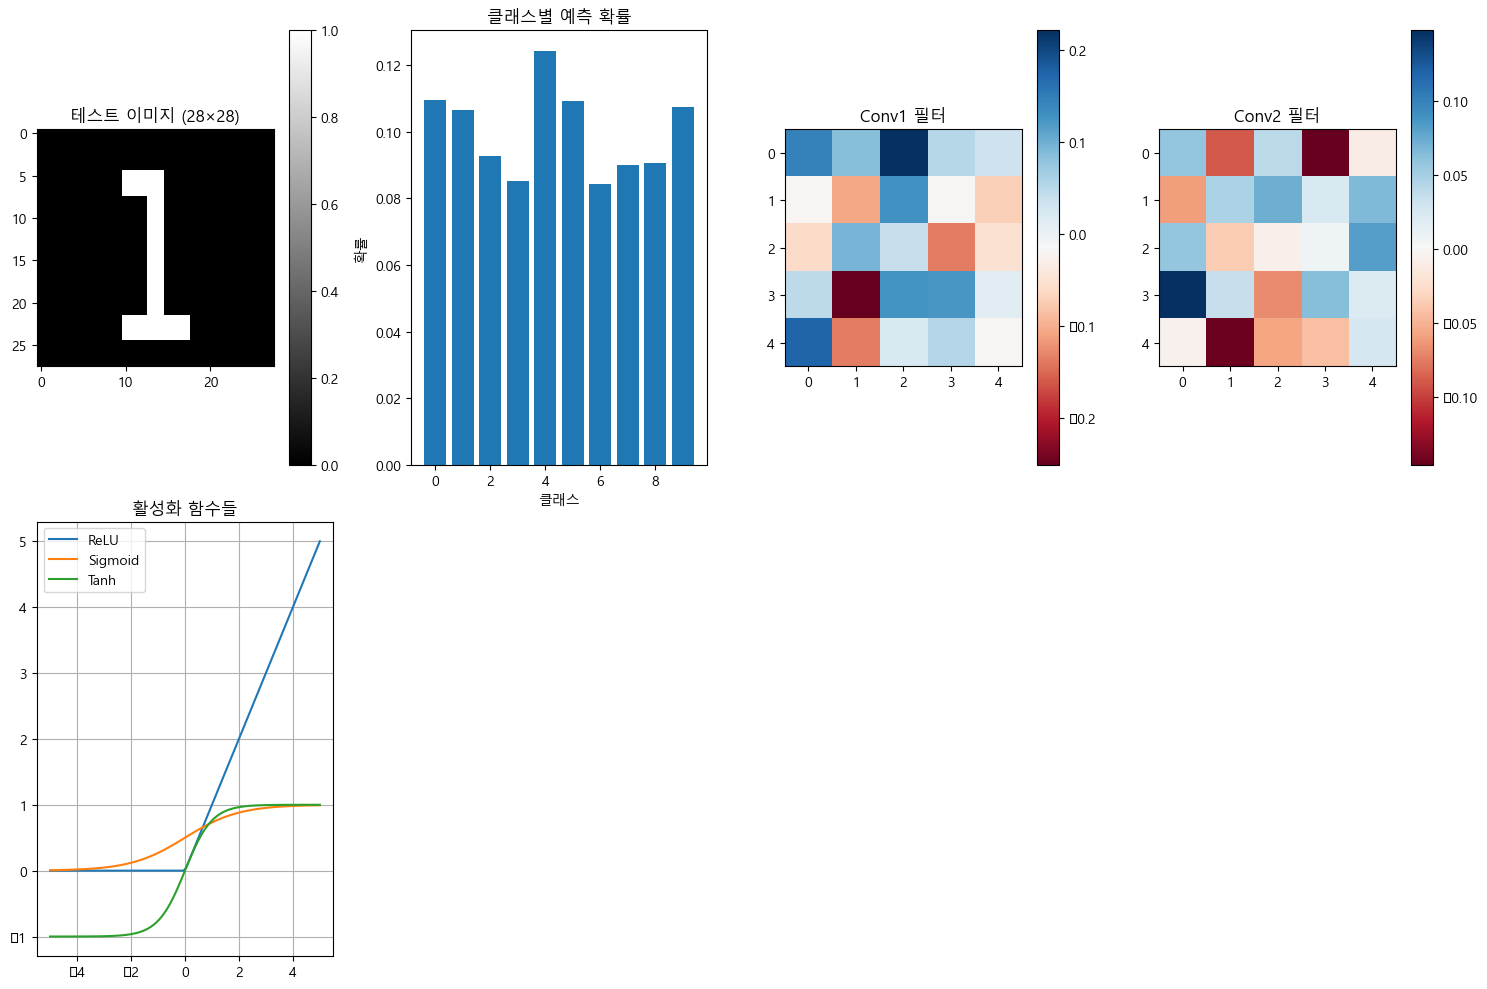


✅ CNN 순전파 성공!

📊 CNN 모델 정보:
총 매개변수 개수: 332
메모리 사용량 (대략): 1.3 KB

✅ 간단한 CNN 구현 및 테스트 완료!


In [4]:
# 함수로 간단한 CNN 구현하기
print("=== 함수 기반 CNN 구현 ===")

# 활성화 함수들
def relu(x):
    """ReLU 활성화 함수"""
    return torch.maximum(x, torch.zeros_like(x))

def sigmoid(x):
    """Sigmoid 활성화 함수"""
    return 1 / (1 + torch.exp(-x))

def softmax(x):
    """Softmax 활성화 함수"""
    exp_x = torch.exp(x - torch.max(x))  # 수치적 안정성을 위해
    return exp_x / torch.sum(exp_x)

# CNN 층 함수들
def conv_layer(input_map, weights, bias, activation='relu'):
    """
    컨볼루션 층 (컨볼루션 + 활성화 함수)
    
    Args:
        input_map: 입력 특성 맵
        weights: 필터 가중치
        bias: 편향
        activation: 활성화 함수 ('relu', 'sigmoid', 'tanh')
    
    Returns:
        output: 활성화 함수가 적용된 특성 맵
    """
    # 컨볼루션 연산
    conv_output = convolution_2d(input_map, weights)
    
    # 편향 추가
    conv_output += bias
    
    # 활성화 함수 적용
    if activation == 'relu':
        return relu(conv_output)
    elif activation == 'sigmoid':
        return sigmoid(conv_output)
    elif activation == 'tanh':
        return torch.tanh(conv_output)
    else:
        return conv_output  # 활성화 함수 없음

def pool_layer(feature_map, pool_type='max', pool_size=2, stride=2):
    """
    풀링 층
    
    Args:
        feature_map: 입력 특성 맵
        pool_type: 풀링 타입 ('max', 'avg')
        pool_size: 풀링 윈도우 크기
        stride: 스트라이드
    
    Returns:
        output: 풀링된 특성 맵
    """
    if pool_type == 'max':
        return max_pooling_2d(feature_map, pool_size, stride)
    elif pool_type == 'avg':
        return average_pooling_2d(feature_map, pool_size, stride)
    else:
        raise ValueError("pool_type must be 'max' or 'avg'")

def flatten_layer(feature_map):
    """2D 특성 맵을 1D 벡터로 변환"""
    return feature_map.reshape(-1)

def dense_layer(input_vector, weights, bias, activation=None):
    """
    완전연결층 (Dense Layer)
    
    Args:
        input_vector: 입력 벡터
        weights: 가중치 행렬
        bias: 편향 벡터
        activation: 활성화 함수
    
    Returns:
        output: 출력 벡터
    """
    # 선형 변환
    output = torch.matmul(weights, input_vector) + bias
    
    # 활성화 함수 적용
    if activation == 'relu':
        return relu(output)
    elif activation == 'sigmoid':
        return sigmoid(output)
    elif activation == 'softmax':
        return softmax(output)
    else:
        return output

# 간단한 CNN 모델 구현 (LeNet 스타일)
def simple_cnn_forward(input_image, parameters):
    """
    간단한 CNN 순전파
    
    Args:
        input_image: 입력 이미지 (28×28)
        parameters: 모델 매개변수 딕셔너리
    
    Returns:
        output: 최종 출력 (10개 클래스 확률)
    """
    print(f"입력 이미지 크기: {input_image.shape}")
    
    # 첫 번째 컨볼루션 층
    conv1_output = conv_layer(
        input_image, 
        parameters['conv1_weight'], 
        parameters['conv1_bias'],
        activation='relu'
    )
    print(f"Conv1 출력 크기: {conv1_output.shape}")
    
    # 첫 번째 풀링 층
    pool1_output = pool_layer(conv1_output, pool_type='max', pool_size=2, stride=2)
    print(f"Pool1 출력 크기: {pool1_output.shape}")
    
    # 두 번째 컨볼루션 층
    conv2_output = conv_layer(
        pool1_output,
        parameters['conv2_weight'],
        parameters['conv2_bias'], 
        activation='relu'
    )
    print(f"Conv2 출력 크기: {conv2_output.shape}")
    
    # 두 번째 풀링 층
    pool2_output = pool_layer(conv2_output, pool_type='max', pool_size=2, stride=2)
    print(f"Pool2 출력 크기: {pool2_output.shape}")
    
    # Flatten 층
    flattened = flatten_layer(pool2_output)
    print(f"Flatten 출력 크기: {flattened.shape}")
    
    # 첫 번째 완전연결층
    fc1_output = dense_layer(
        flattened,
        parameters['fc1_weight'], 
        parameters['fc1_bias'],
        activation='relu'
    )
    print(f"FC1 출력 크기: {fc1_output.shape}")
    
    # 두 번째 완전연결층 (출력층)
    fc2_output = dense_layer(
        fc1_output,
        parameters['fc2_weight'],
        parameters['fc2_bias'],
        activation='softmax'
    )
    print(f"FC2 (출력) 크기: {fc2_output.shape}")
    
    return fc2_output

# 모델 매개변수 초기화 (랜덤)
print("\n=== 모델 매개변수 초기화 ===")

# 간단한 CNN 구조 정의
# 입력: 28×28 → Conv(5×5, 6) → Pool(2×2) → Conv(5×5, 16) → Pool(2×2) → FC(120) → FC(10)

parameters = {
    # 첫 번째 컨볼루션 층 (6개 필터, 5×5)
    'conv1_weight': torch.randn(5, 5) * 0.1,  # 단순화: 1개 필터만
    'conv1_bias': torch.randn(1) * 0.1,
    
    # 두 번째 컨볼루션 층 (16개 필터, 5×5) 
    'conv2_weight': torch.randn(5, 5) * 0.1,  # 단순화: 1개 필터만
    'conv2_bias': torch.randn(1) * 0.1,
    
    # 첫 번째 완전연결층 (입력: 16, 출력: 10) - 단순화
    'fc1_weight': torch.randn(10, 16) * 0.1,
    'fc1_bias': torch.randn(10) * 0.1,
    
    # 두 번째 완전연결층 (출력층: 10개 클래스)
    'fc2_weight': torch.randn(10, 10) * 0.1,
    'fc2_bias': torch.randn(10) * 0.1
}

print("매개변수 초기화 완료:")
for name, param in parameters.items():
    print(f"  {name}: {param.shape}")

# 28×28 테스트 이미지 생성 (간단한 숫자 모양)
print(f"\n=== 테스트 이미지 생성 ===")

# 숫자 '1' 모양의 간단한 이미지
test_digit = torch.zeros(28, 28)
test_digit[5:25, 13:15] = 1.0  # 세로줄
test_digit[5:8, 10:15] = 1.0   # 위쪽 기울어진 부분
test_digit[22:25, 10:18] = 1.0 # 아래쪽 밑줄

print(f"테스트 이미지 크기: {test_digit.shape}")
print(f"이미지 픽셀 값 범위: {test_digit.min():.1f} ~ {test_digit.max():.1f}")

# 이미지 시각화
plt.figure(figsize=(15, 10))

# 테스트 이미지
plt.subplot(2, 4, 1)
plt.imshow(test_digit, cmap='gray')
plt.title('테스트 이미지 (28×28)')
plt.colorbar()

# CNN 순전파 실행
print(f"\n=== CNN 순전파 실행 ===")
try:
    final_output = simple_cnn_forward(test_digit, parameters)
    
    print(f"\n최종 출력 (10개 클래스 확률):")
    for i, prob in enumerate(final_output):
        print(f"  클래스 {i}: {prob:.4f}")
    
    # 예측 결과
    predicted_class = torch.argmax(final_output)
    print(f"\n예측된 클래스: {predicted_class.item()}")
    print(f"예측 확률: {final_output[predicted_class]:.4f}")
    
    # 출력 확률 시각화
    plt.subplot(2, 4, 2)
    plt.bar(range(10), final_output.detach().numpy())
    plt.title('클래스별 예측 확률')
    plt.xlabel('클래스')
    plt.ylabel('확률')
    
    # 매개변수 일부 시각화
    plt.subplot(2, 4, 3)
    plt.imshow(parameters['conv1_weight'], cmap='RdBu')
    plt.title('Conv1 필터')
    plt.colorbar()
    
    plt.subplot(2, 4, 4)
    plt.imshow(parameters['conv2_weight'], cmap='RdBu')
    plt.title('Conv2 필터')
    plt.colorbar()
    
    # 활성화 함수들 시각화
    x = torch.linspace(-5, 5, 100)
    
    plt.subplot(2, 4, 5)
    plt.plot(x, relu(x), label='ReLU')
    plt.plot(x, sigmoid(x), label='Sigmoid')
    plt.plot(x, torch.tanh(x), label='Tanh')
    plt.title('활성화 함수들')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ CNN 순전파 성공!")
    
except Exception as e:
    print(f"❌ 오류 발생: {e}")
    print("매개변수 크기를 조정해야 할 수 있습니다.")

print(f"\n📊 CNN 모델 정보:")
total_params = sum(param.numel() for param in parameters.values())
print(f"총 매개변수 개수: {total_params:,}")
print(f"메모리 사용량 (대략): {total_params * 4 / 1024:.1f} KB")  # float32 기준

print("\n✅ 간단한 CNN 구현 및 테스트 완료!")


## 4. 강의 정리 및 다음 단계

### 4.1 오늘 배운 핵심 내용

**🎯 11강에서 완전히 이해한 것들:**

1. **CNN의 필요성**
   - 기존 신경망의 한계 (매개변수 폭증, 위치 정보 손실)
   - CNN의 해결책 (지역적 연결, 가중치 공유, 계층적 학습)

2. **컨볼루션 연산**
   - 필터를 이용한 특성 추출 과정
   - 스트라이드, 패딩 등 하이퍼파라미터 효과
   - 다양한 필터의 역할 (엣지 검출, 블러, 샤프닝)

3. **풀링 연산**
   - 차원 축소와 불변성 확보
   - Max Pooling vs Average Pooling
   - 계산량 감소와 오버피팅 방지 효과

4. **함수 기반 CNN 구현**
   - 각 층을 함수로 모듈화
   - 순전파 과정 단계별 이해
   - 실제 동작하는 CNN 코드 완성

### 4.2 핵심 공식 정리

**📐 중요한 공식들:**

```
🔹 컨볼루션 출력 크기:
   출력 = (입력 - 커널 + 2×패딩) / 스트라이드 + 1

🔹 매개변수 개수:
   Conv층 = (커널크기 × 입력채널 + 1) × 출력채널
   FC층 = (입력뉴런 + 1) × 출력뉴런

🔹 수용 영역 크기:
   깊이가 깊어질수록 더 넓은 영역을 "볼" 수 있음
```

### 4.3 CNN 설계 원칙

**🏗️ 좋은 CNN을 만드는 법칙:**

1. **점진적 축소**: 이미지 크기는 줄이고, 채널 수는 늘림
2. **작은 필터 선호**: 3×3 필터를 여러 번 쌓는 것이 효과적
3. **적절한 깊이**: 너무 얕으면 표현력 부족, 너무 깊으면 학습 어려움
4. **정규화 기법**: 배치 정규화, 드롭아웃 등으로 성능 향상

### 4.4 실무에서 CNN 사용하기

**💼 실제 프로젝트에서의 CNN:**

| 분야 | 적용 예시 | 주요 기법 |
|------|-----------|-----------|
| **의료** | X-ray 판독, 병리 분석 | 전이학습, 데이터 증강 |
| **자율주행** | 신호등 인식, 차선 검출 | 실시간 처리, 엣지 컴퓨팅 |
| **보안** | 얼굴 인식, 이상 탐지 | 높은 정확도, 오류 최소화 |
| **쇼핑** | 상품 검색, 추천 시스템 | 대용량 처리, 빠른 응답 |

### 4.5 12강 미리보기

**🔮 다음 강의 예고 - "CNN 모델 구현과 이미지 분류":**

1. **실제 MNIST 데이터 사용**
   - 진짜 손글씨 숫자 데이터셋 로드
   - 데이터 전처리와 정규화

2. **성능 평가와 개선**
   - 정확도, 손실 함수 모니터링
   - 하이퍼파라미터 튜닝

3. **시각화와 해석**
   - 학습된 필터 시각화
   - 특성 맵 분석
   - 잘못 분류된 사례 분석

### 4.6 마무리

**🎉 축하합니다!**

오늘 여러분은 **딥러닝의 핵심인 CNN을 완전히 이해**했습니다!

- ✅ 컨볼루션과 풀링 연산을 손으로 계산할 수 있습니다
- ✅ CNN이 왜 이미지 처리에 효과적인지 설명할 수 있습니다  
- ✅ 함수로 CNN을 직접 구현해봤습니다
- ✅ 실제 동작하는 CNN 코드를 완성했습니다
